### Brief data analysis 

In [1]:
import pandas as pd
import tensorflow as tf
import json
from pandas.core.frame import DataFrame

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.utils.np_utils import to_categorical


In [2]:
import tensorflow as tf
tf.__version__


'2.10.0'

In [3]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
tf.debugging.set_log_device_placement(True)

In [4]:
df = pd.read_json("train_data.json",encoding="utf-8", orient='records')
df

,text,id,relation_list,entity_list
0,Massachusetts ASTON MAGNA Great Barrington ; a...,train_0,"[{'subject': 'Annandale-on-Hudson', 'object': ...","[{'text': 'Annandale-on-Hudson', 'type': 'DEFA..."
1,North Carolina EASTERN MUSIC FESTIVAL Greensbo...,train_1,"[{'subject': 'North Carolina', 'object': 'Gree...","[{'text': 'North Carolina', 'type': 'DEFAULT',..."
2,It will be the final movie credited to Debra H...,train_2,"[{'subject': 'Debra Hill', 'object': 'Haddonfi...","[{'text': 'Debra Hill', 'type': 'DEFAULT', 'ch..."
3,In a 3-0 victory over the Crew on Saturday in ...,train_3,"[{'subject': 'Ohio', 'object': 'Columbus', 'su...","[{'text': 'Ohio', 'type': 'DEFAULT', 'char_spa..."
4,"The United States ambassador to Mexico , Tony ...",train_4,"[{'subject': 'Mexico', 'object': 'Nuevo Laredo...","[{'text': 'Mexico', 'type': 'DEFAULT', 'char_s..."
...,...,...,...,...
56191,"Tanna 's big draw is Mount Yasur , one of the ...",train_56191,"[{'subject': 'Tanna', 'object': 'Mount Yasur',...","[{'text': 'Tanna', 'type': 'DEFAULT', 'char_sp..."
56192,We flew Air Pacific -LRB- 800-227-4446 ; www.a...,train_56192,"[{'subject': 'Vanuatu', 'object': 'Port Vila',...","[{'text': 'Vanuatu', 'type': 'DEFAULT', 'char_..."
56193,"I think Westchester is changing , '' said Kenn...",train_56193,"[{'subject': 'Kenneth T. Jackson', 'object': '...","[{'text': 'Kenneth T. Jackson', 'type': 'DEFAU..."
56194,Here we have a 172-acre island with four-star ...,train_56194,"[{'subject': 'Ellis Island', 'object': 'Manhat...","[{'text': 'Ellis Island', 'type': 'DEFAULT', '..."


In [5]:
df["text"].value_counts()

35th Avenue at 36th Street , Astoria , Queens , (718) 784-0077 ; $ 10 .                                                                                                                                                                  31
This prodigious show , by an artist born and still living in Columbus , Ohio , celebrates her heritage in paintings , drawings , sculpture , stitchery , leather work and less classifiable forms of expression .                        20
22-25 Jackson Avenue , at 46th Avenue , Long Island City , Queens , (718)784-2084 .                                                                                                                                                      17
BAM Rose Cinemas , 30 Lafayette Avenue , at Ashland Place , Fort Greene , Brooklyn , (718) 636-4100 ; $ 10 .                                                                                                                             16
MUSEUM OF THE MOVING IMAGE , 36-01 35th Avenue , Astoria

In [30]:
n_most_common_words =30000

### Data preprocess

In [31]:
def data_process(train_file,valid_file,test_file,n_most_common_words):
    
    #tf.debugging.set_log_device_placement(True)
    df = pd.read_json(train_file,encoding="utf-8", orient='records')
    with open("rel2id.json","r") as f:
        rel2id = json.load(f)
        id2rel = {k:v for k, v in rel2id.items()}
        num_classes = len(rel2id)
        
        
    #n_most_common_words = 50000 # vocabulary size
    max_len = 100
# Initialization
    tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;=?@[]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(df['text'].values)
    print(len(tokenizer.word_index) + 1)
    
    X_train = input_process(tokenizer,df,max_len)
    label_train = label_process(df,id2rel)
    
    df_valid = pd.read_json(valid_file,encoding="utf-8", orient='records')
    X_valid = input_process(tokenizer,df_valid,max_len)
    label_valid = label_process(df_valid,id2rel)
    
    df_test = pd.read_json(test_file,encoding="utf-8", orient='records')
    X_test = input_process(tokenizer,df_test,max_len)
    label_test = label_process(df_test,id2rel)
    

    
    return X_train, label_train, X_valid, label_valid, X_test, label_test 

def input_process(tokenizer,df,max_len):
    sequences = tokenizer.texts_to_sequences(df['text'].values)
    #word_index = tokenizer.word_index
    X = pad_sequences(sequences, maxlen=max_len)
    return X

def label_process(df_object,relate_label):
    label=[df_object["relation_list"][i][0]["predicate"] for i in range(df_object.shape[0])]
    train_label = [relate_label[i] for i in label]
    labels=DataFrame(train_label)
    labels = to_categorical(labels, num_classes=24)
    return labels
    

In [32]:
X_train, y_train, X_validation, y_validation,X_test,y_test = data_process("train_data.json","valid_data.json","test_data.json", n_most_common_words)

64179


In [16]:
import numpy as np
total = 0
for i in X_train:
    number = np.count_nonzero(i > 0)
    if(number == 100):
        total+=1
print(total)

0


In [34]:
y_train.shape

(56196, 24)

In [33]:
from keras import Sequential
from keras.layers import *
def generate_model(embedding_size, n_most_common_words, output, learning_rate):
    model = Sequential()
    model.add(Embedding(n_most_common_words, embedding_size, input_length=X_train.shape[1]))
    model.add(Bidirectional(LSTM(output, dropout=0.5, recurrent_dropout=0.5)))
    model.add(Dense(y_train.shape[1], activation='relu'))
    model.compile(tf.keras.optimizers.Adam(lr = learning_rate),loss='categorical_crossentropy', metrics=['acc'])
    print(model.summary())
    return model

In [35]:
model = generate_model(100,n_most_common_words,128,0.001)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          3000000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 24)                6168      
                                                                 
Total params: 3,240,664
Trainable params: 3,240,664
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\qiuji\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
lr_set = []

In [36]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [37]:
from tensorflow.python.client import device_lib
print(tf.test.is_built_with_cuda())
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print(gpus)

 
 
print(device_lib.list_local_devices())

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4848012800028890172
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5717884928
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13882482248138388141
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


In [38]:
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data = (X_validation, y_validation),workers=4)
#model.fit(X_train, y_train, epochs=3, batch_size=128, validation_split=0.2)


Epoch 1/10
440/440 [==============================] - 330s 734ms/step - loss: 2.3974 - acc: 0.5252 - val_loss: 2.5288 - val_acc: 0.5266
Epoch 2/10
440/440 [==============================] - 330s 751ms/step - loss: 2.3444 - acc: 0.5382 - val_loss: 1.9063 - val_acc: 0.5266
Epoch 3/10
440/440 [==============================] - 324s 737ms/step - loss: 1.8236 - acc: 0.5429 - val_loss: 1.7379 - val_acc: 0.5656
Epoch 4/10
440/440 [==============================] - 329s 747ms/step - loss: 1.5990 - acc: 0.6024 - val_loss: 1.6810 - val_acc: 0.5772
Epoch 5/10
440/440 [==============================] - 334s 758ms/step - loss: 1.4840 - acc: 0.6332 - val_loss: 1.5754 - val_acc: 0.6348
Epoch 6/10
440/440 [==============================] - 329s 749ms/step - loss: 1.4946 - acc: 0.6360 - val_loss: 1.7040 - val_acc: 0.6250
Epoch 7/10
440/440 [==============================] - 314s 714ms/step - loss: 1.2452 - acc: 0.6763 - val_loss: 2.1970 - val_acc: 0.6416
Epoch 8/10
440/440 [============================

In [ ]:
lr_set = [0.001,0.0005]
emb_set = [10,100]
val_loss_set=[]
val_acc_set=[]
for i in lr_set:
    for e in emb_set:
        model = generate_model(e,n_most_common_words,128,i)
        model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data = (X_validation, y_validation),workers=4)
        val_loss_set.append(model.history.history["val_loss"])
        val_acc_set.append(model.history.history["val_acc"])


In [43]:
model.history.history["val_loss"]

[2.5287842750549316,
 1.9063090085983276,
 1.7378844022750854,
 1.6810482740402222,
 1.575364589691162,
 1.7039589881896973,
 2.196972131729126,
 1.741001009941101,
 1.7580677270889282,
 1.760731816291809]

In [40]:
import matplotlib.pyplot as plt

def show_train_history(train_history,train_metrics,val_metrics):
    plt.plot(train_history[train_metrics])
    plt.plot(train_history[val_metrics])
    plt.title('Train History')
    plt.ylabel(train_metrics)
    plt.xlabel('epoch')
    plt.legend(['train','validation'],loc='upper left')
    
    plt.show()


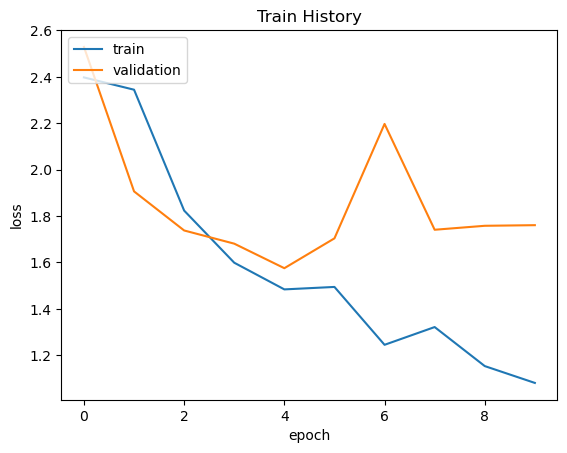

In [41]:
show_train_history(model.history.history,'loss','val_loss')

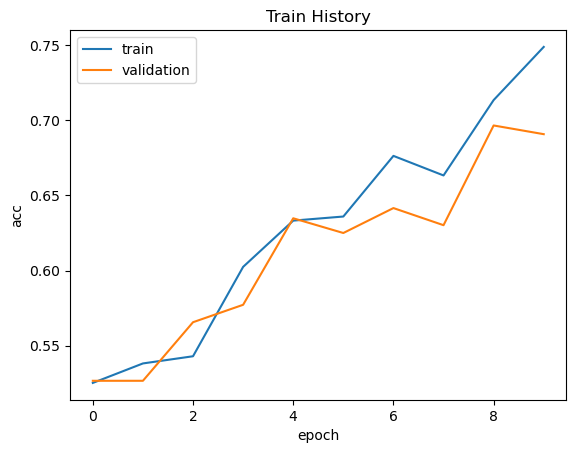

In [42]:
show_train_history(model.history.history,'acc','val_acc')

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [44]:
from sklearn.metrics import *
prediction_probas = model.predict(X_test) 


157/157 [==============================] - 12s 72ms/step


In [40]:
predictions[0]

10

In [45]:
import numpy as np
from sklearn.metrics import confusion_matrix
predictions = [np.argmax(pred) for pred in prediction_probas]
digit_y = [np.argmax(i)for i in y_test]
print(confusion_matrix(digit_y, predictions)) #from sklearn.metrics
print(classification_report(digit_y, predictions, digits=3))

[[   0    0    0    0    0    3    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   0    0    0    0    0   23    0    0    0    2    0    0    0    0
     1    3    0    0    0    0]
 [   0    0    0    0    0   12    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   0    0    0    0    0    4    0    0    0   19    0    2    0    0
     2    2    0    0    0    0]
 [   0    0    0    0    0   13    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   0    0    0    0    0  322    0    0    0   23    0    0    0    0
     7    8    0    0    0    0]
 [   0    0    0    0    0    0   10   65    0   65    0    0    0    0
    16    0    0    0    0    0]
 [   0    0    0    0    0    1    2   59    1   65    0    0    0    0
    13    1    0    0    0    0]
 [   0    0    0    0    0    4    5   29   22  162    0    1    0    0
    44    1    0    0    0    0]
 [   0    0    0    0    0   46   10   62   17 2246    

C:\Users\qiuji\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\qiuji\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\qiuji\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
import seaborn as sns
import matplotlib.pyplot as plt



In [46]:
text_str=[]
data = confusion_matrix(digit_y, predictions)
for i in range(24):
  x=[]
  for j in range(24):
    x.append(str(data[i][j]))
  text_str.append(x)


ax = sns.heatmap(data, cmap='RdYlGn',vmin=0, vmax=5**3, annot=text_str,fmt="")

xxx = [i for i in range(24)]
xxxs = [str(i) for i in range(24)]
plt.xticks(xxx,xxxs,rotation=45)
plt.yticks(xxx,('0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23'),rotation=45)

#We are imagining that the squares in the heat-map are function values corresponding to domain points, [20,40,60,80]x[100,200,300]
plt.title("Heatmap Plot Title")
plt.xlabel("X-axis Labels")
plt.ylabel("Y-axes Labels")


plt.show()


IndexError: index 20 is out of bounds for axis 0 with size 20

In [47]:
data

array([[   0,    0,    0,    0,    0,    3,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,   23,    0,    0,    0,    2,    0,
           0,    0,    0,    1,    3,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,   12,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    4,    0,    0,    0,   19,    0,
           2,    0,    0,    2,    2,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,   13,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,  322,    0,    0,    0,   23,    0,
           0,    0,    0,    7,    8,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,   10,   65,    0,   65,    0,
           0,    0,    0,   16,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    